In [1]:
# !pip install --no-cache-dir --extra-index-url https://pypi.nvidia.com cugraph-cu11

In [ ]:
# !chmod +x run_experiment.sh
# !./run_experiment.sh

In [53]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, glob, os, torch, math, torchvision, datetime
from tqdm.notebook import tqdm 
import torch.nn.functional as F
import configparser

# my files
from cmgraph import parse_gcs, image_to_world, GCSDatasetLoaderStatic, DatasetLoaderStatic
from models import DenseGCNGRU, GRU_only, GCNGRU, A3TGCN_2, TGCN_2
# from pyheatmap.heatmap import HeatMap
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [129]:
checkpoint_dict_list = []
for root, dirs, files in os.walk('./checkpoints'): 
    for name in files: 
        path = os.path.join(root, name)
        checkpoint_dict = torch.load(path)
        new_dict = checkpoint_dict.copy()
        new_dict['model'] = name.split('_')[0]
        new_dict['path'] = path
        new_dict['forecasting_horizon'] = name.split('_')[-2]
        new_dict['dataset'] = name.split('_')[-3]
        if new_dict['dataset'] == '2023': 
            new_dict['dataset'] = 'STADIUM_2023'
        del new_dict['model_state_dict']
        del new_dict['optimizer_state_dict']
        checkpoint_dict_list.append(new_dict)
results_df = pd.DataFrame(checkpoint_dict_list)
for k in ['forecasting_horizon', 'test_mae', 'test_mse']:
    results_df[k] = pd.to_numeric(results_df[k])
results_df.rename({})
results_df.head(3)

epoch     lr                                 train_epoch_losses  \
0     39  0.001  [0.546831165978668, 0.4396056037977201, 0.4244...   
1     39  0.001  [0.40782534966775036, 0.27550753964743485, 0.2...   
2     39  0.001  [0.9753498976880853, 0.9572571028362621, 0.606...   

  val_epoch_losses  test_mse  test_mae        model  \
0               []  0.221994  0.332421       GCNGRU   
1               []  0.078123  0.205895  DenseGCNGRU   
2               []  0.298898  0.353797          GRU   

                                         path  forecasting_horizon dataset  
0       ./checkpoints/GCNGRU_GCS_120_steps.pt                  120     GCS  
1  ./checkpoints/DenseGCNGRU_GCS_120_steps.pt                  120     GCS  
2      ./checkpoints/GRU_only_SEQ_20_steps.pt                   20     SEQ

In [130]:
replacements = {
    'DenseGCNGRU': 'Dense-GCN-GRU',
    'GCNGRU': 'GCN-GRU',
    'STADIUM_2023': 'Stadium'
}

results_df = results_df.replace(replacements, regex=True)

In [131]:
results_df[['forecasting_horizon', 'dataset','model','test_mse','test_mae']].to_csv('results_out.csv')

In [132]:
results_df.query('forecasting_horizon==20')[['dataset','model','test_mse','test_mae']].sort_values(['dataset', 'model'])

dataset          model  test_mse  test_mae
7       GCS  Dense-GCN-GRU  0.090917  0.210042
14      GCS        GCN-GRU  0.260004  0.360371
27      GCS            GRU  0.114267  0.229439
33      SEQ  Dense-GCN-GRU  0.246507  0.333288
10      SEQ        GCN-GRU  0.763934  0.627037
2       SEQ            GRU  0.298898  0.353797
20  Stadium  Dense-GCN-GRU  0.033642  0.129742
26  Stadium        GCN-GRU  0.076488  0.197365
17  Stadium            GRU  0.040549  0.142259

In [133]:
results_df.query('forecasting_horizon==20')[['dataset','model','test_mse','test_mae']].sort_values(['dataset', 'model']).groupby('model').agg({'test_mse': 'mean', 'test_mae': 'mean'})

test_mse  test_mae
model                            
Dense-GCN-GRU  0.123689  0.224357
GCN-GRU        0.366809  0.394924
GRU            0.151238  0.241832

In [134]:
results_df.query('forecasting_horizon==20')[['dataset','model','test_mse','test_mae']].sort_values(['dataset', 'model']).pivot(index='dataset', columns='model', values='test_mse')

model    Dense-GCN-GRU   GCN-GRU       GRU
dataset                                   
GCS           0.090917  0.260004  0.114267
SEQ           0.246507  0.763934  0.298898
Stadium       0.033642  0.076488  0.040549

In [135]:
results_df.query('forecasting_horizon==240')[['dataset','model','test_mse','test_mae']].sort_values(['dataset', 'model'])

dataset          model  test_mse  test_mae
11      GCS  Dense-GCN-GRU  0.092426  0.219488
18      GCS        GCN-GRU  0.225523  0.333851
30      GCS            GRU  0.157527  0.284396
24      SEQ  Dense-GCN-GRU  0.336476  0.409502
9       SEQ        GCN-GRU  0.782397  0.644679
4       SEQ            GRU  0.965484  0.771505
16  Stadium  Dense-GCN-GRU  0.035781  0.140002
34  Stadium        GCN-GRU  0.047798  0.160320
23  Stadium            GRU  0.077680  0.201283

In [136]:
results_df.query('forecasting_horizon==240')[['dataset','model','test_mse','test_mae']].sort_values(['dataset', 'model']).groupby('model').agg({'test_mse': 'mean', 'test_mae': 'mean'})

test_mse  test_mae
model                            
Dense-GCN-GRU  0.154894  0.256331
GCN-GRU        0.351906  0.379617
GRU            0.400231  0.419061

In [137]:
results_df.query('forecasting_horizon==240')[['dataset','model','test_mse','test_mae']].sort_values(['dataset', 'model']).pivot(index='dataset', columns='model', values='test_mse')

model    Dense-GCN-GRU   GCN-GRU       GRU
dataset                                   
GCS           0.092426  0.225523  0.157527
SEQ           0.336476  0.782397  0.965484
Stadium       0.035781  0.047798  0.077680

# Table & Plot 1: GCS results

In [123]:
gcs_results = results_df.query('dataset=="GCS"')[['forecasting_horizon','model','test_mse','test_mae',]].sort_values(by=['forecasting_horizon','model'])
gcs_results.to_markdown(index='False')

'|   forecasting_horizon | model         |   test_mse |   test_mae |\n|----------------------:|:--------------|-----------:|-----------:|\n|                    20 | Dense-GCN-GRU |  0.0909171 |   0.210042 |\n|                    20 | GCN-GRU       |  0.260004  |   0.360371 |\n|                    20 | GRU           |  0.114267  |   0.229439 |\n|                    60 | Dense-GCN-GRU |  0.0870501 |   0.212329 |\n|                    60 | GCN-GRU       |  0.255839  |   0.353357 |\n|                    60 | GRU           |  0.176345  |   0.293152 |\n|                   120 | Dense-GCN-GRU |  0.078123  |   0.205895 |\n|                   120 | GCN-GRU       |  0.221994  |   0.332421 |\n|                   120 | GRU           |  0.1384    |   0.268725 |\n|                   240 | Dense-GCN-GRU |  0.0924262 |   0.219488 |\n|                   240 | GCN-GRU       |  0.225523  |   0.333851 |\n|                   240 | GRU           |  0.157527  |   0.284396 |'

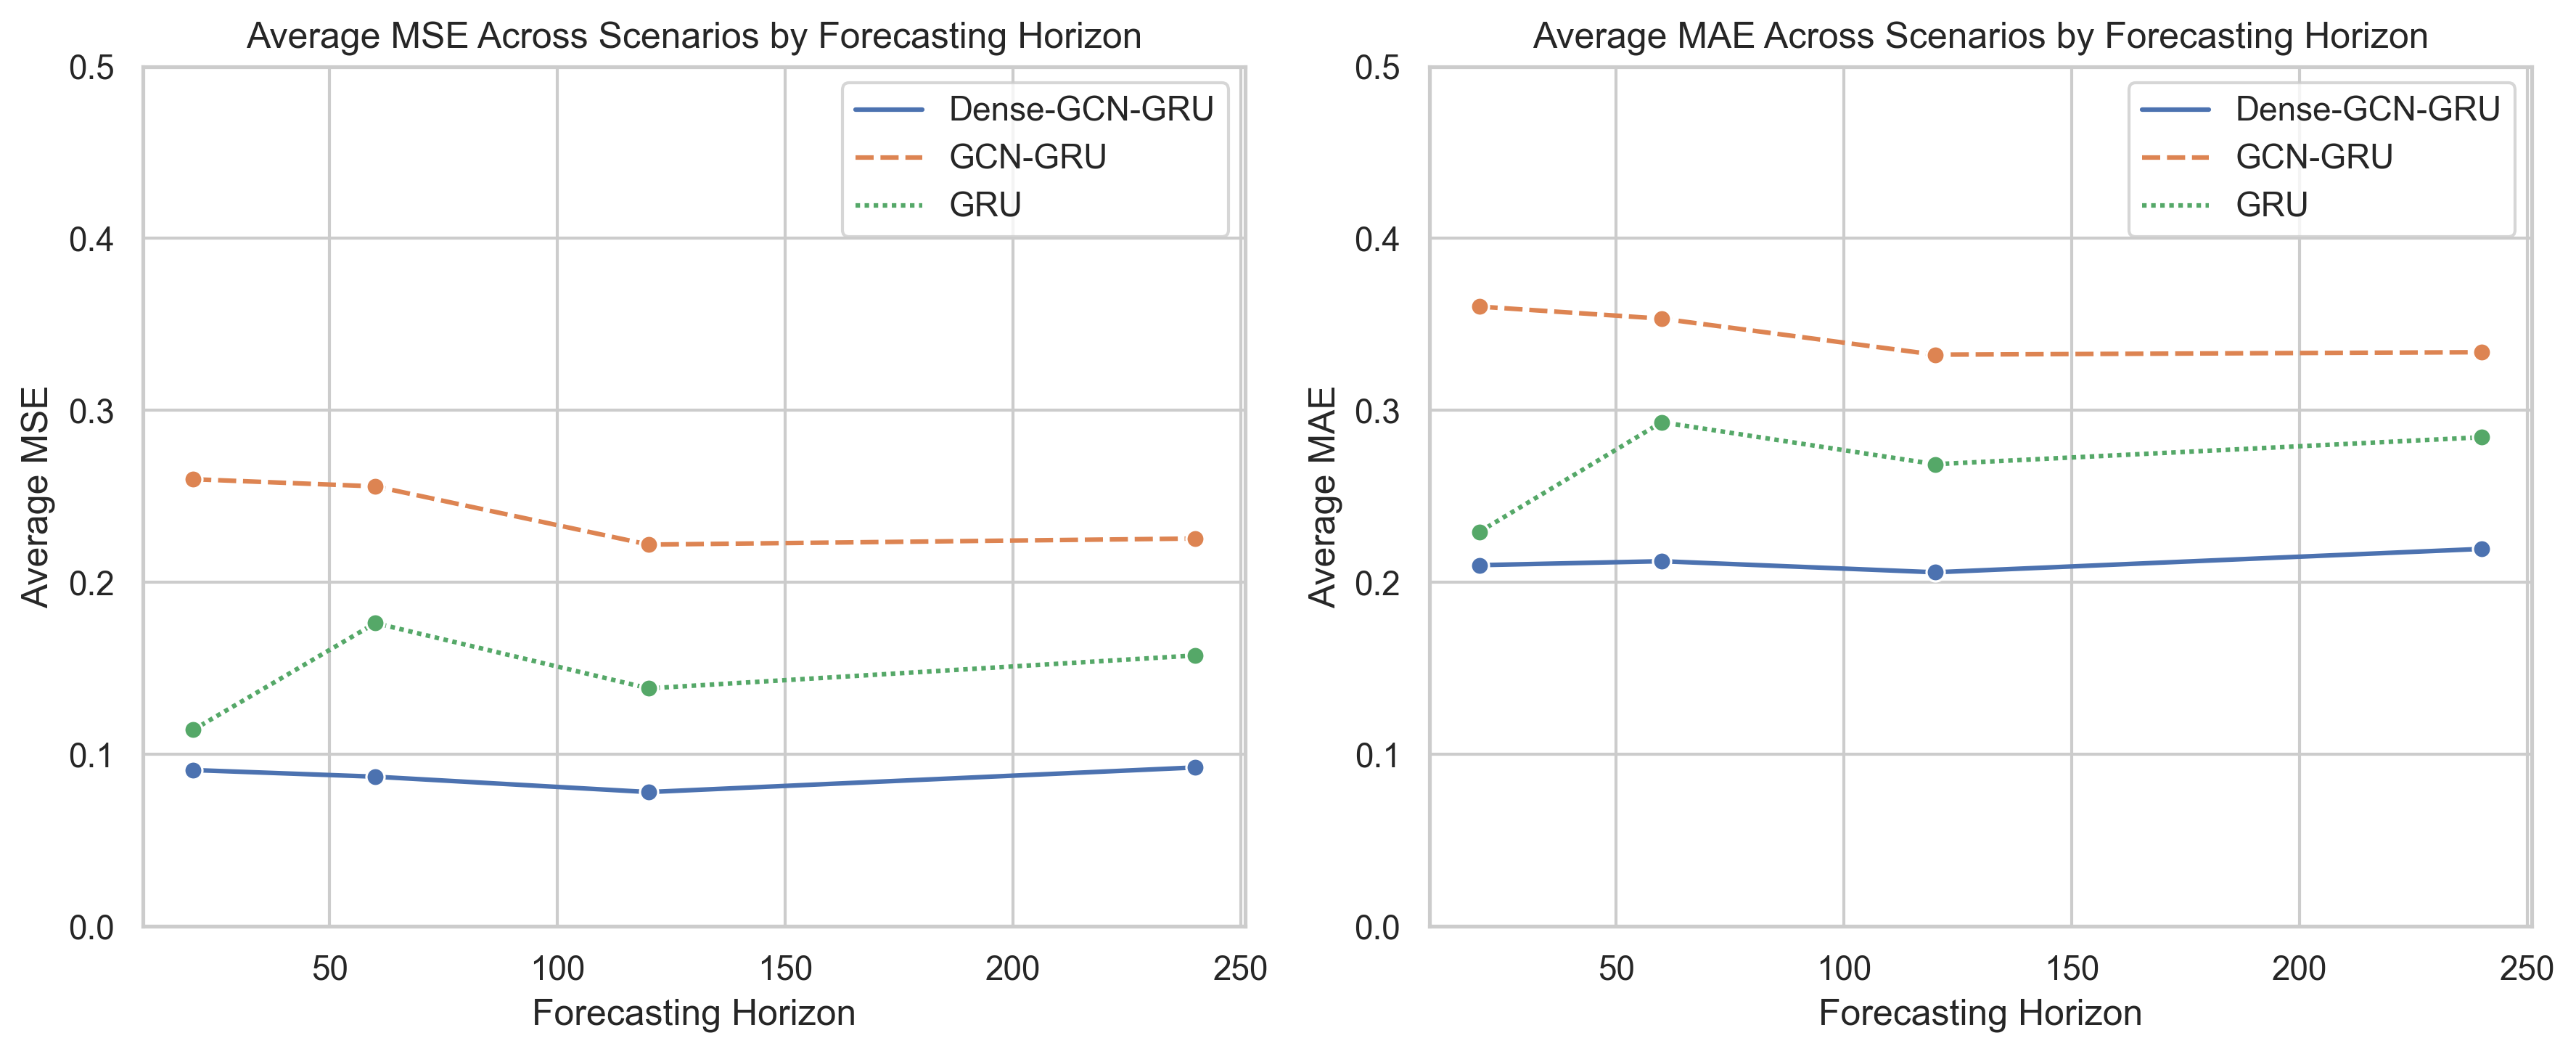

In [127]:
# Pivot the data for easier plotting
mse_pivot = gcs_results.pivot("forecasting_horizon", "model", "test_mse")
mae_pivot = gcs_results.pivot("forecasting_horizon", "model", "test_mae")

# Line plot for MSE
plt.figure(figsize=(12, 5),dpi=300)
plt.subplot(1, 2, 1)
sns.lineplot(data=mse_pivot, marker='o')
plt.title('Average MSE Across Scenarios by Forecasting Horizon')
plt.ylabel('Average MSE')
plt.xlabel('Forecasting Horizon')
plt.legend(loc='upper right')
plt.ylim((0,0.5))

# Line plot for MAE
plt.subplot(1, 2, 2)
sns.lineplot(data=mae_pivot, marker='o')
plt.title('Average MAE Across Scenarios by Forecasting Horizon')
plt.ylabel('Average MAE')
plt.xlabel('Forecasting Horizon')
plt.legend(loc='upper right')
plt.ylim((0,0.5))

# Adjust layout
plt.tight_layout()
plt.show()

# Table & Plot 2: MSE and MAE at 20 and 240 steps across Campus Crowd data subsets

In [155]:
cc_results = results_df.query('dataset.isin(["Stadium", "SEQ"])')[['dataset','forecasting_horizon','model','test_mse','test_mae',]].sort_values(by=['dataset','forecasting_horizon','model'])
# cc_results.to_markdown(index='False')
cc_results

dataset  forecasting_horizon          model  test_mse  test_mae
33      SEQ                   20  Dense-GCN-GRU  0.246507  0.333288
10      SEQ                   20        GCN-GRU  0.763934  0.627037
2       SEQ                   20            GRU  0.298898  0.353797
22      SEQ                   60  Dense-GCN-GRU  0.245608  0.329055
5       SEQ                   60        GCN-GRU  0.494309  0.460872
19      SEQ                   60            GRU  0.363938  0.412361
6       SEQ                  120  Dense-GCN-GRU  0.281856  0.350016
13      SEQ                  120        GCN-GRU  0.414673  0.433164
28      SEQ                  120            GRU  0.515549  0.476942
24      SEQ                  240  Dense-GCN-GRU  0.336476  0.409502
9       SEQ                  240        GCN-GRU  0.782397  0.644679
4       SEQ                  240            GRU  0.965484  0.771505
20  Stadium                   20  Dense-GCN-GRU  0.033642  0.129742
26  Stadium                   20        GCN-GRU  0.076488  0.197365
17  Stadium                   20            GRU  0.040549  0.142259
35  Stadium                   60  Dense-GCN-GRU  0.038301  0.142583
32  Stadium                   60        GCN-GRU  0.064791  0.187805
12  Stadium                   60            GRU  0.058688  0.178056
29  Stadium                  120  Dense-GCN-GRU  0.034493  0.140188
31  Stadium                  120        GCN-GRU  0.073483  0.193232
3   Stadium                  120            GRU  0.073666  0.200660
16  Stadium                  240  Dense-GCN-GRU  0.035781  0.140002
34  Stadium                  240        GCN-GRU  0.047798  0.160320
23  Stadium                  240            GRU  0.077680  0.201283

In [156]:
horizon_20_data = cc_results.query('forecasting_horizon==20')[['dataset','model','test_mse','test_mae']].sort_values(by=['dataset','model'])

# Grouping by model and dataset, then calculating the mean MSE and MAE for horizon 20
model_dataset_performance_horizon_20 = horizon_20_data.groupby(['model', 'dataset'])[['test_mse', 'test_mae']].mean().reset_index()

# Sorting the data for better visualization
model_dataset_performance_horizon_20_sorted = model_dataset_performance_horizon_20.sort_values(by=['dataset','model'])

model_dataset_performance_horizon_20_sorted.round(3)

model  dataset  test_mse  test_mae
0  Dense-GCN-GRU      SEQ     0.247     0.333
2        GCN-GRU      SEQ     0.764     0.627
4            GRU      SEQ     0.299     0.354
1  Dense-GCN-GRU  Stadium     0.034     0.130
3        GCN-GRU  Stadium     0.076     0.197
5            GRU  Stadium     0.041     0.142

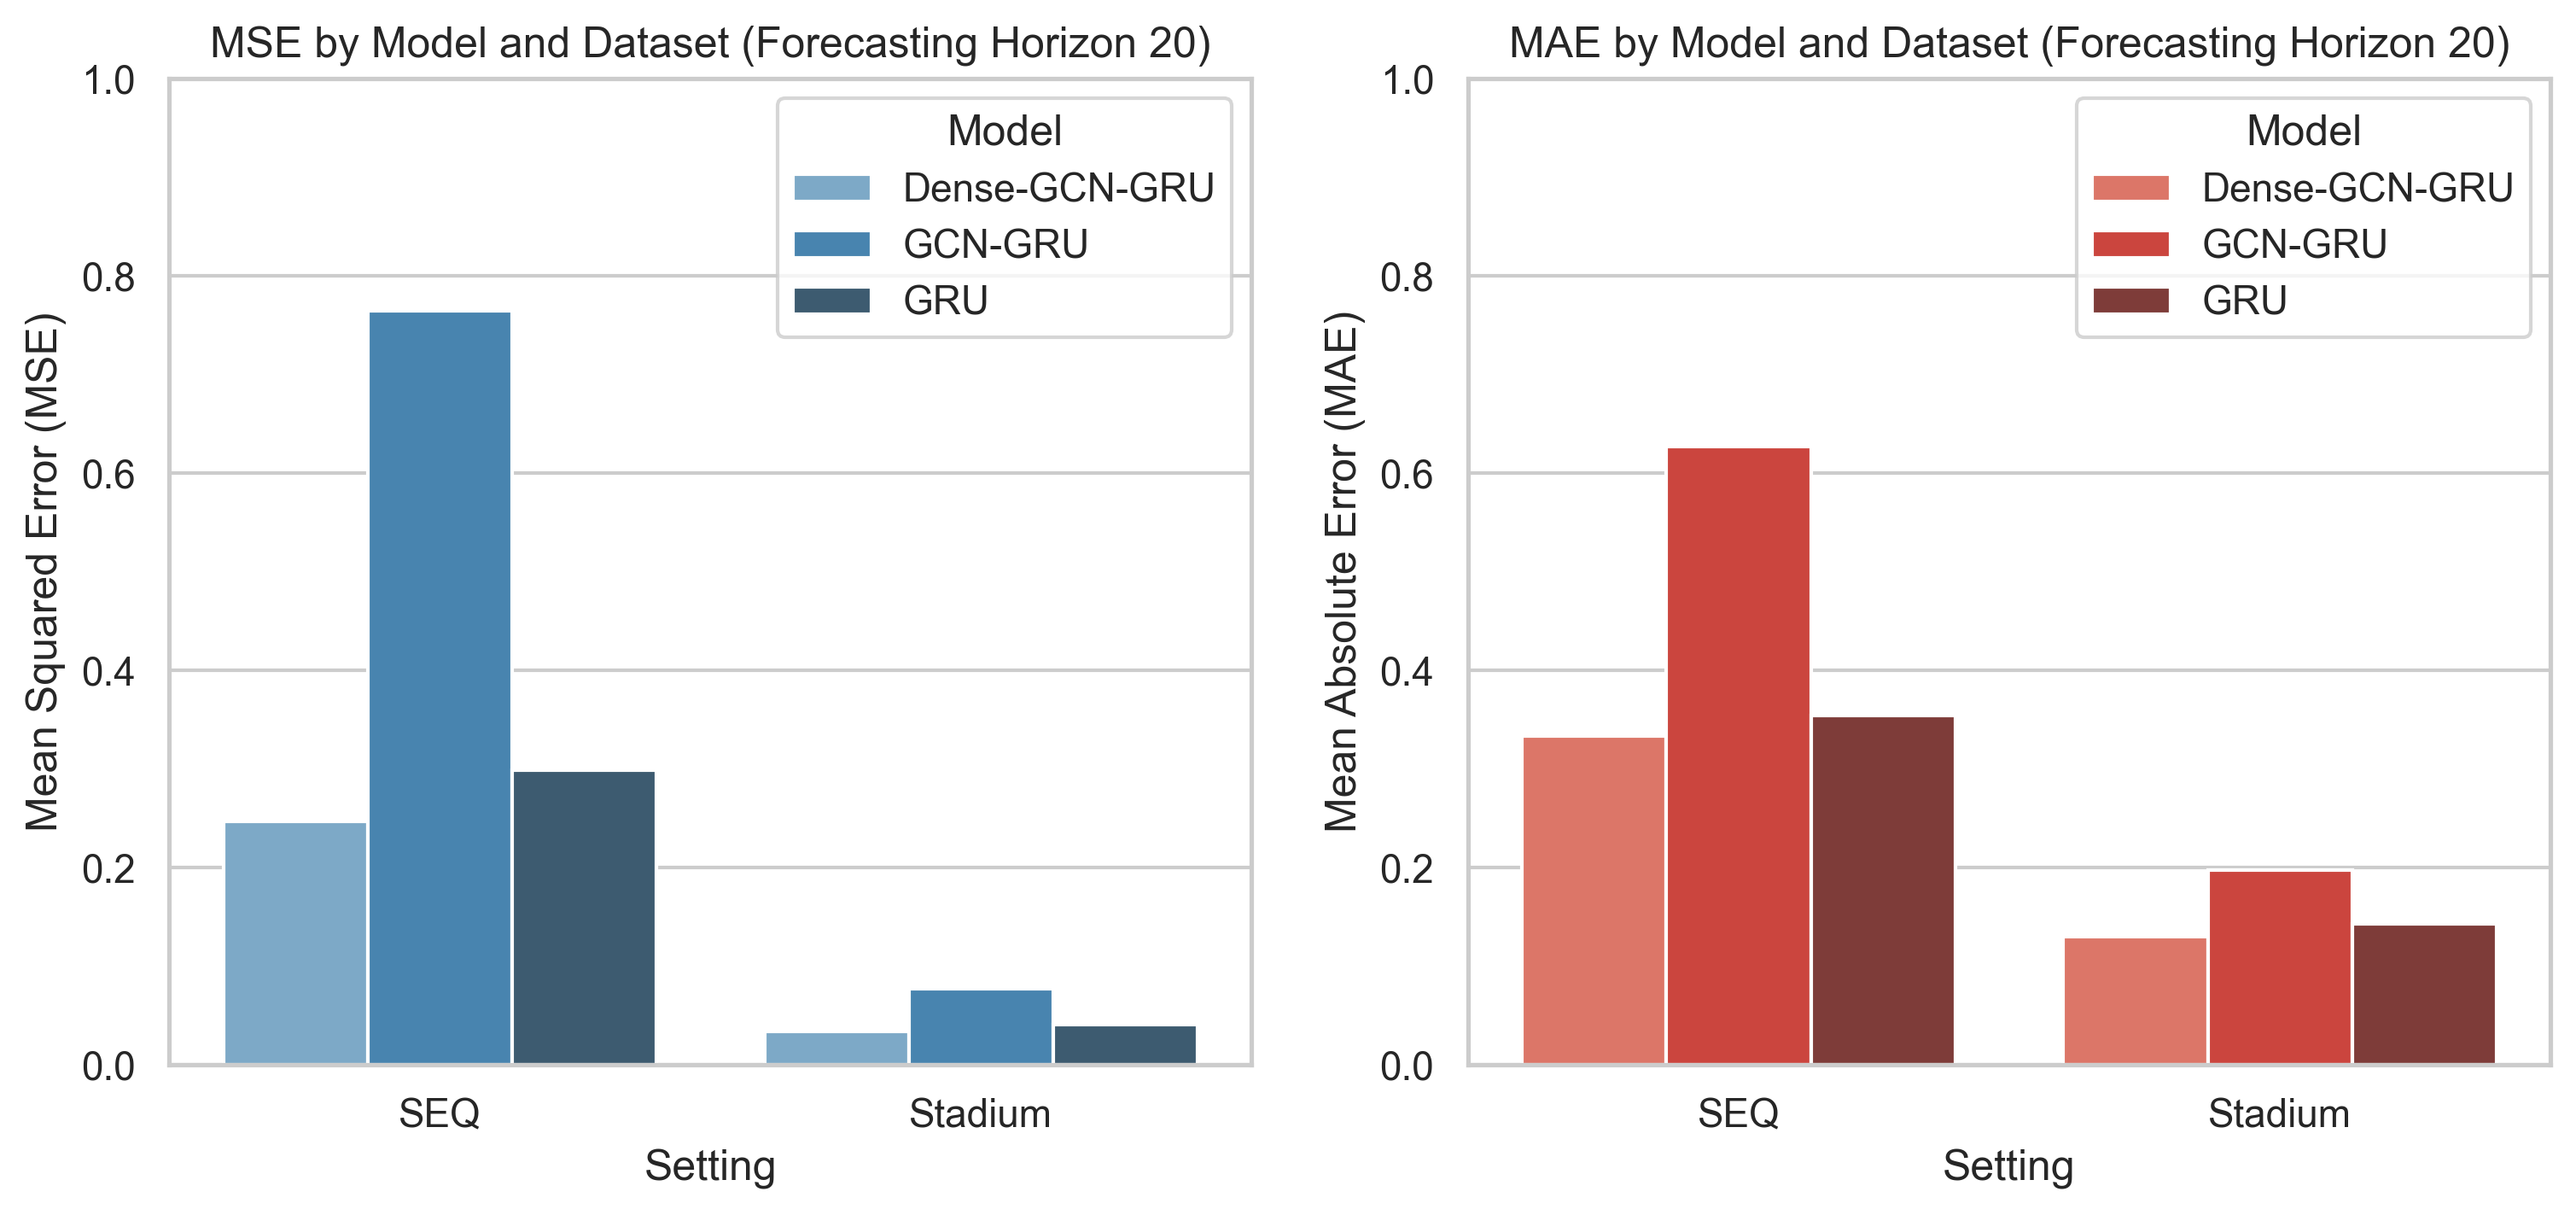

In [158]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram Plot for MSE
plt.figure(figsize=(12, 5),dpi=300)
plt.subplot(1, 2, 1)
sns.barplot(x='dataset', y='test_mse', hue='model', data=horizon_20_data, palette='Blues_d')
plt.title('MSE by Model and Dataset (Forecasting Horizon 20)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Setting')
plt.legend(title='Model')
plt.ylim((0,1))

# Histogram Plot for MAE
plt.subplot(1, 2, 2)
sns.barplot(x='dataset', y='test_mae', hue='model', data=horizon_20_data, palette='Reds_d')
plt.title('MAE by Model and Dataset (Forecasting Horizon 20)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Setting')
plt.legend(title='Model')
plt.ylim((0,1))
plt.show()

In [159]:
horizon_240_data = cc_results.query('forecasting_horizon==240')[['dataset','model','test_mse','test_mae']].sort_values(by=['dataset','model'])

# Grouping by model and dataset, then calculating the mean MSE and MAE for horizon 240
model_dataset_performance_horizon_240 = horizon_240_data.groupby(['model', 'dataset'])[['test_mse', 'test_mae']].mean().reset_index()

# Sorting the data for better visualization
model_dataset_performance_horizon_240_sorted = model_dataset_performance_horizon_240.sort_values(by=['dataset','model'])

model_dataset_performance_horizon_240_sorted.round(3)

model  dataset  test_mse  test_mae
0  Dense-GCN-GRU      SEQ     0.336     0.410
2        GCN-GRU      SEQ     0.782     0.645
4            GRU      SEQ     0.965     0.772
1  Dense-GCN-GRU  Stadium     0.036     0.140
3        GCN-GRU  Stadium     0.048     0.160
5            GRU  Stadium     0.078     0.201

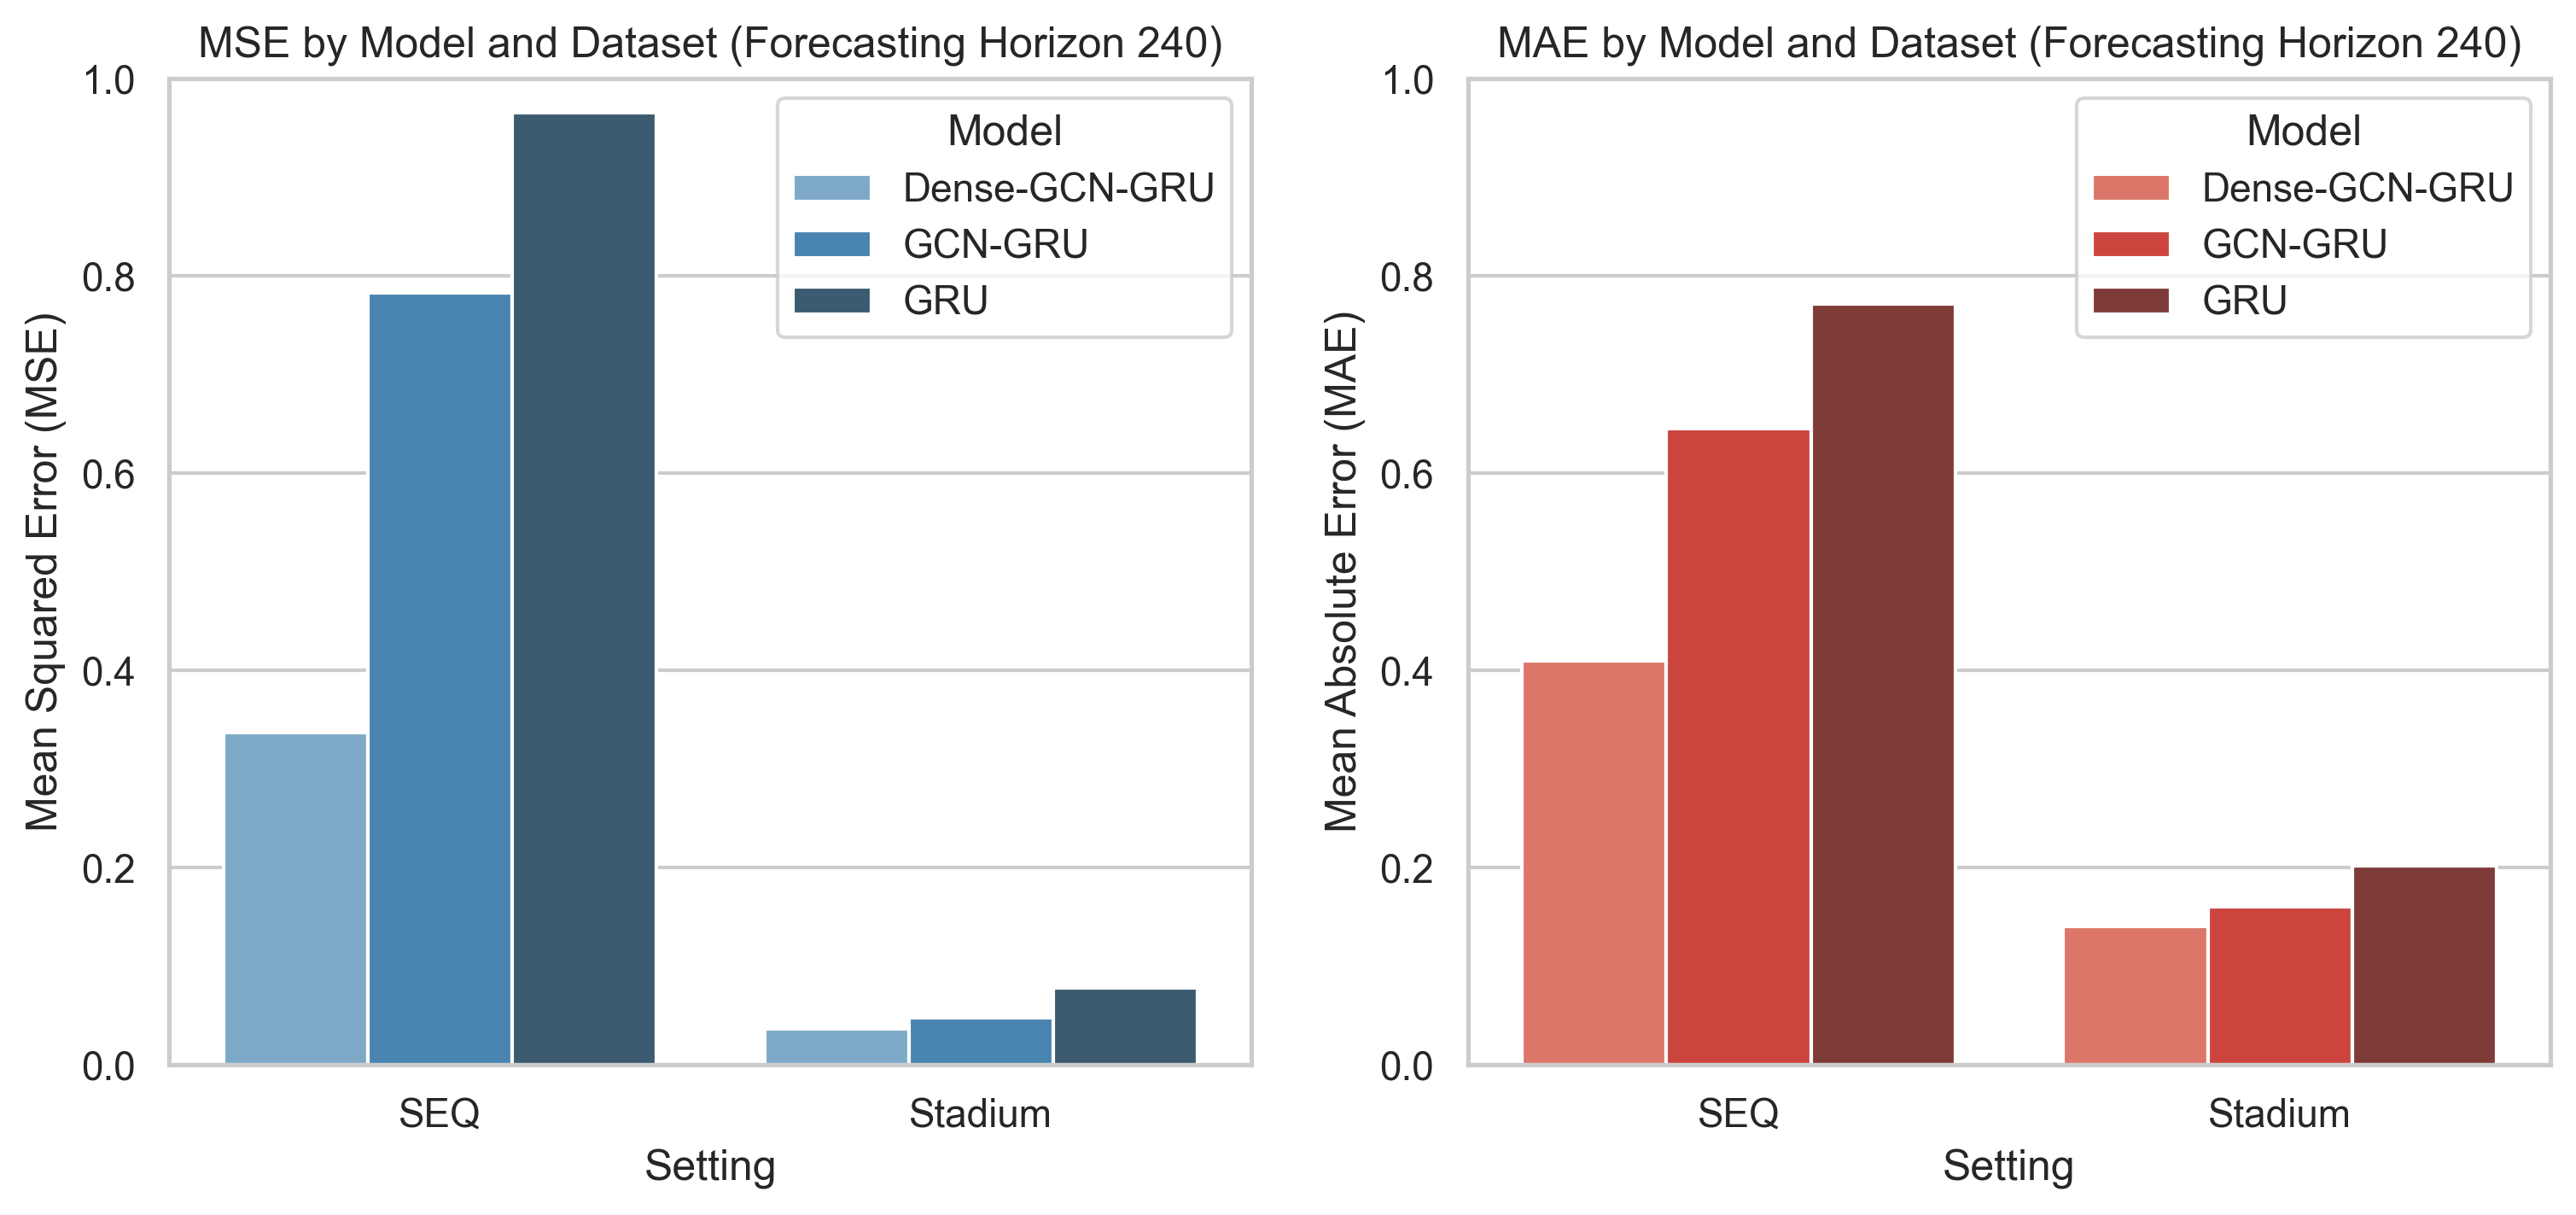

In [160]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram Plot for MSE
plt.figure(figsize=(12, 5),dpi=300)
plt.subplot(1, 2, 1)
sns.barplot(x='dataset', y='test_mse', hue='model', data=horizon_240_data, palette='Blues_d')
plt.title('MSE by Model and Dataset (Forecasting Horizon 240)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Setting')
plt.legend(title='Model')
plt.ylim((0,1))

# Histogram Plot for MAE
plt.subplot(1, 2, 2)
sns.barplot(x='dataset', y='test_mae', hue='model', data=horizon_240_data, palette='Reds_d')
plt.title('MAE by Model and Dataset (Forecasting Horizon 240)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Setting')
plt.legend(title='Model')
plt.ylim((0,1))
plt.show()

# Table & Plot 3: MSE and MAE at various steps, averaged over all data subsets. 

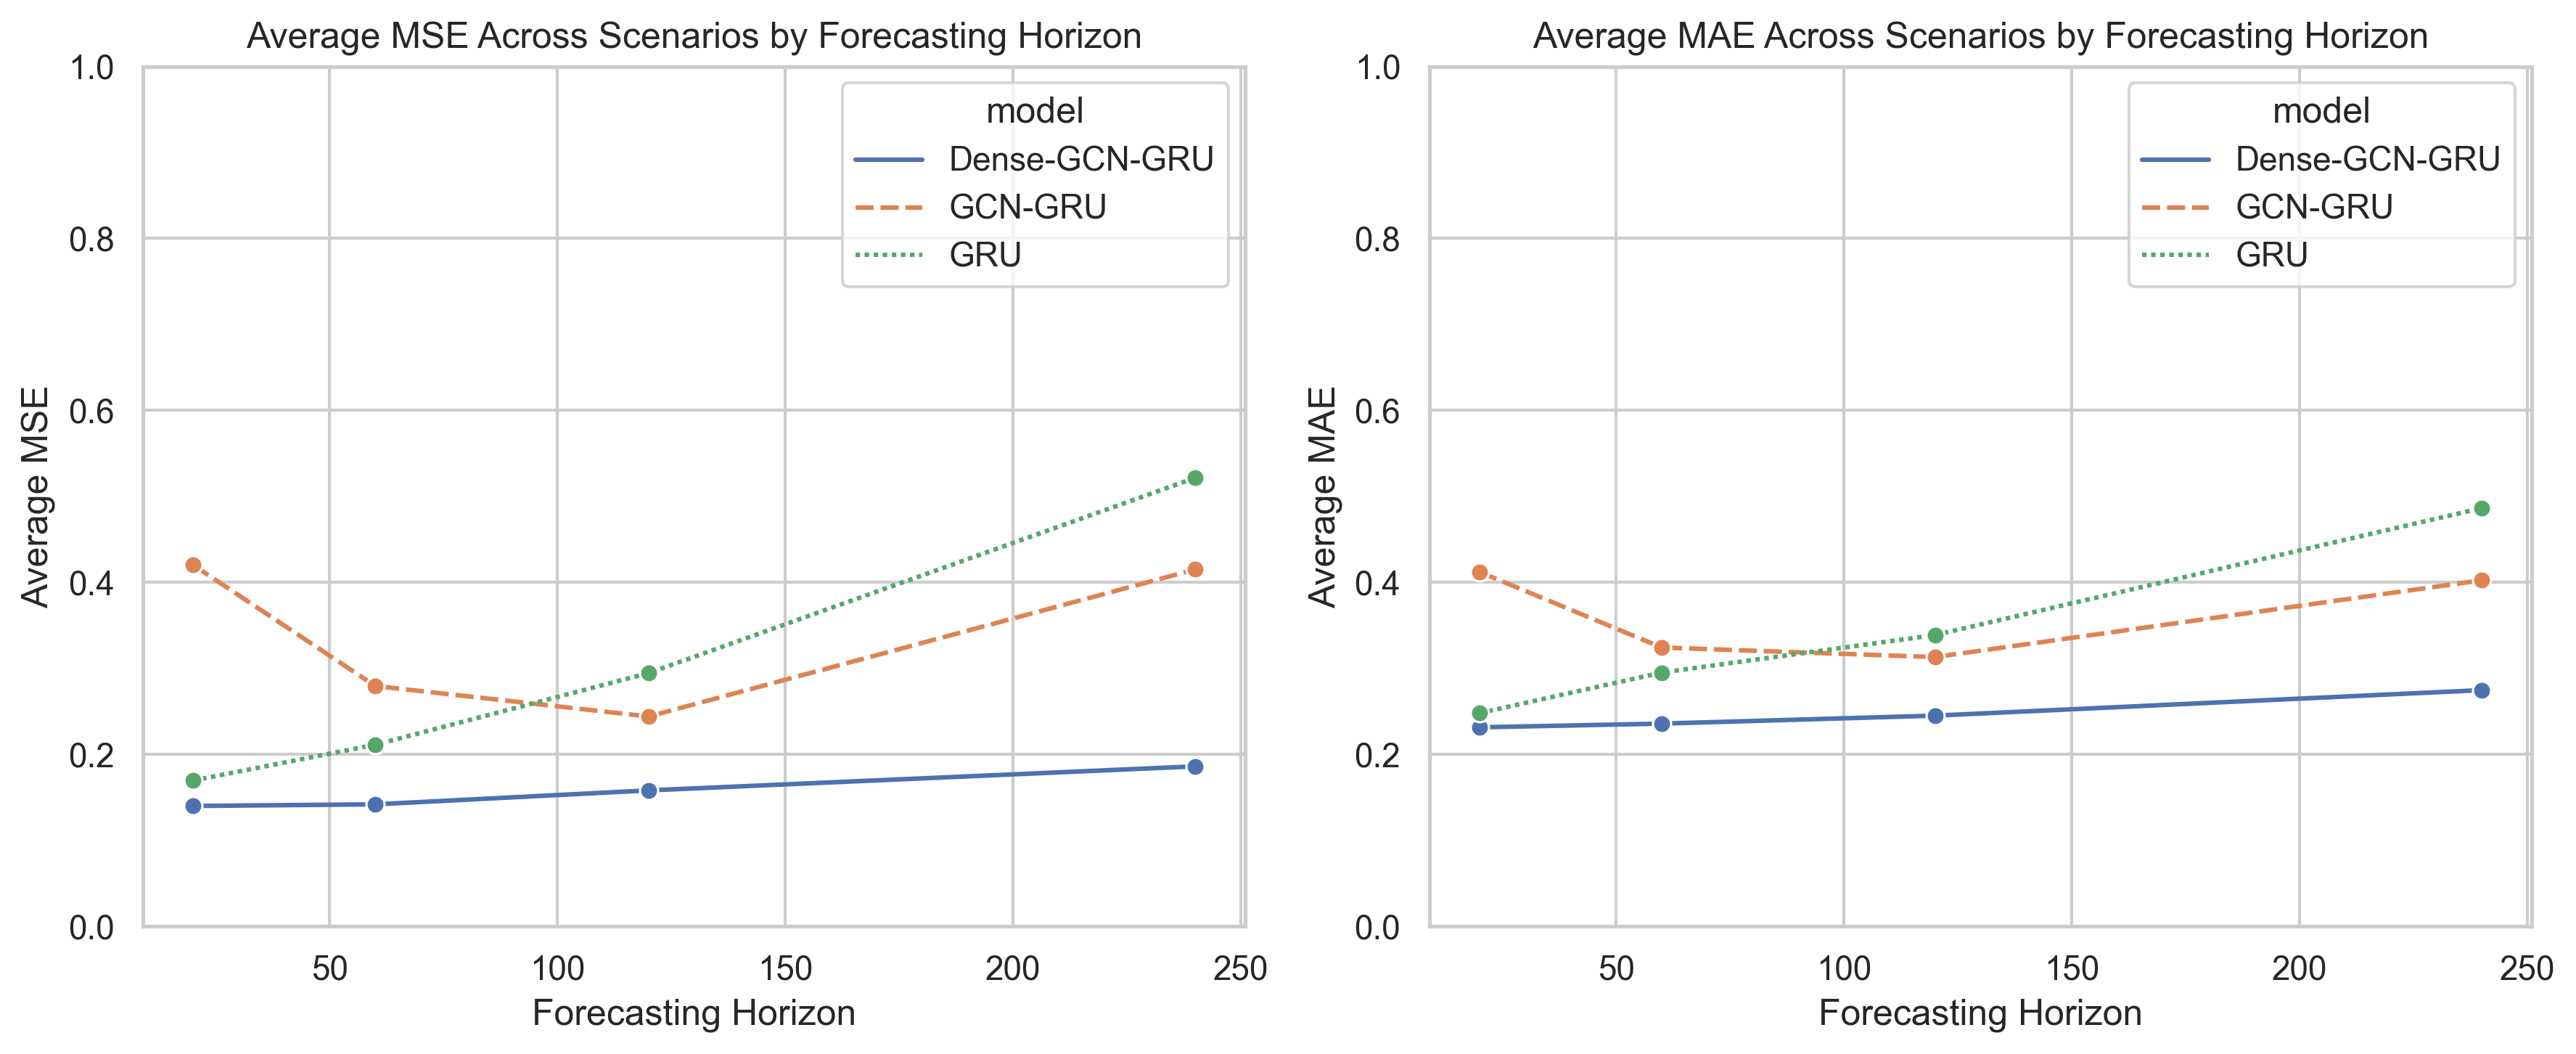

In [161]:
# Averaging MSE and MAE across datasets for each forecasting horizon and model
avg_performance = cc_results.groupby(['forecasting_horizon', 'model']).mean().reset_index()

# Pivot the data for easier plotting
mse_pivot = avg_performance.pivot("forecasting_horizon", "model", "test_mse")
mae_pivot = avg_performance.pivot("forecasting_horizon", "model", "test_mae")

# Line plot for MSE
plt.figure(figsize=(12, 5),dpi=300)
plt.subplot(1, 2, 1)
sns.lineplot(data=mse_pivot, marker='o')
plt.title('Average MSE Across Scenarios by Forecasting Horizon')
plt.ylabel('Average MSE')
plt.xlabel('Forecasting Horizon')
plt.ylim((0,1))

# Line plot for MAE
plt.subplot(1, 2, 2)
sns.lineplot(data=mae_pivot, marker='o')
plt.title('Average MAE Across Scenarios by Forecasting Horizon')
plt.ylabel('Average MAE')
plt.xlabel('Forecasting Horizon')
plt.ylim((0,1))

# Adjust layout
plt.tight_layout()
plt.show()

In [36]:
avg_performance

forecasting_horizon        model  epoch     lr  test_mse  test_mae
0                    20  DenseGCNGRU   39.0  0.001  0.123689  0.224357
1                    20       GCNGRU   39.0  0.001  0.366809  0.394924
2                    20          GRU   39.0  0.001  0.151238  0.241832
3                    60  DenseGCNGRU   39.0  0.001  0.123653  0.227989
4                    60       GCNGRU   39.0  0.001  0.271646  0.334012
5                    60          GRU   39.0  0.001  0.199657  0.294523
6                   120  DenseGCNGRU   39.0  0.001  0.131491  0.232033
7                   120       GCNGRU   39.0  0.001  0.236717  0.319605
8                   120          GRU   39.0  0.001  0.242538  0.315443
9                   240  DenseGCNGRU   39.0  0.001  0.154894  0.256331
10                  240       GCNGRU   39.0  0.001  0.351906  0.379617
11                  240          GRU   39.0  0.001  0.400231  0.419061

# plot for presentation

In [71]:
horizon_20_data['model'].replace('DenseGCNGRU', 'Our Model', inplace=True)
horizon_20_data['model'].replace('GRU', 'Baseline', inplace=True)
horizon_20_data = horizon_20_data[(horizon_20_data['dataset'] != 'GCS') & (horizon_20_data['model'] != 'GCNGRU')]
horizon_20_data

dataset      model  test_mse  test_mae
33           SEQ  Our Model  0.246507  0.333288
2            SEQ   Baseline  0.298898  0.353797
20  STADIUM_2023  Our Model  0.033642  0.129742
17  STADIUM_2023   Baseline  0.040549  0.142259

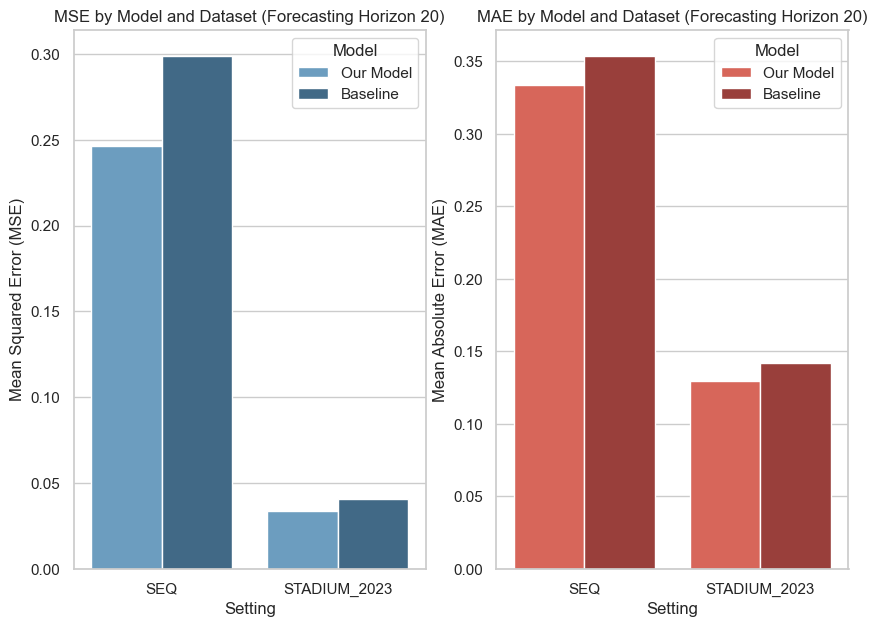

In [78]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram Plot for MSE
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='dataset', y='test_mse', hue='model', data=horizon_20_data, palette='Blues_d')
plt.title('MSE by Model and Dataset (Forecasting Horizon 20)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Setting')
plt.legend(title='Model')

# Histogram Plot for MAE
plt.subplot(1, 2, 2)
sns.barplot(x='dataset', y='test_mae', hue='model', data=horizon_20_data, palette='Reds_d')
plt.title('MAE by Model and Dataset (Forecasting Horizon 20)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Setting')
plt.legend(title='Model')
plt.show()

In [79]:
horizon_240_data['model'].replace('DenseGCNGRU', 'Our Model', inplace=True)
horizon_240_data['model'].replace('GRU', 'Baseline', inplace=True)
horizon_240_data = horizon_240_data[(horizon_240_data['dataset'] != 'GCS') & (horizon_240_data['model'] != 'GCNGRU')]
horizon_240_data

dataset      model  test_mse  test_mae
24           SEQ  Our Model  0.336476  0.409502
4            SEQ   Baseline  0.965484  0.771505
16  STADIUM_2023  Our Model  0.035781  0.140002
23  STADIUM_2023   Baseline  0.077680  0.201283

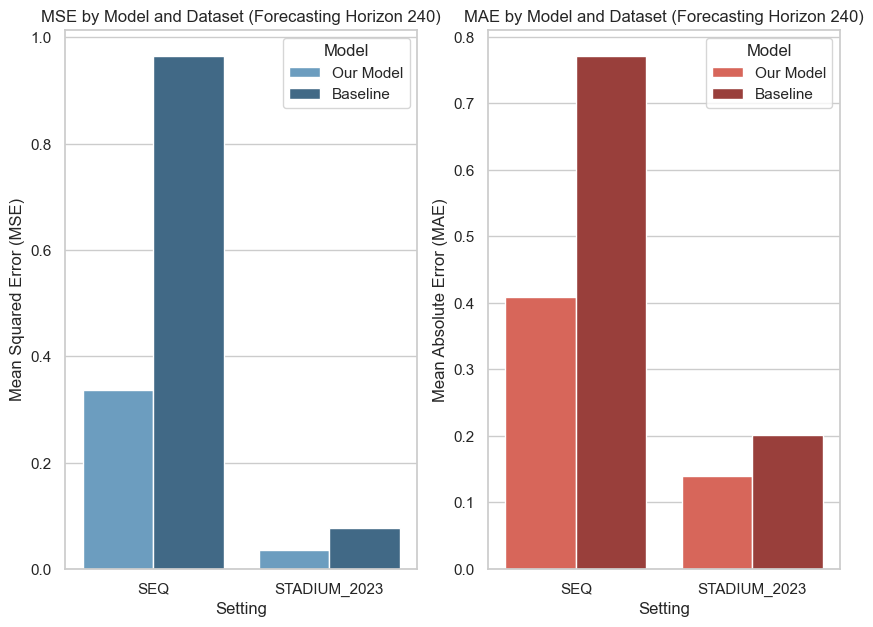

In [81]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram Plot for MSE
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='dataset', y='test_mse', hue='model', data=horizon_240_data, palette='Blues_d')
plt.title('MSE by Model and Dataset (Forecasting Horizon 240)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Setting')
plt.legend(title='Model')

# Histogram Plot for MAE
plt.subplot(1, 2, 2)
sns.barplot(x='dataset', y='test_mae', hue='model', data=horizon_240_data, palette='Reds_d')
plt.title('MAE by Model and Dataset (Forecasting Horizon 240)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Setting')
plt.legend(title='Model')
plt.show()

In [84]:
avg_performance['model'].replace('DenseGCNGRU', 'Our Model', inplace=True)
avg_performance['model'].replace('GRU', 'Baseline', inplace=True)
avg_performance = avg_performance[(avg_performance['model'] != 'GCNGRU')]

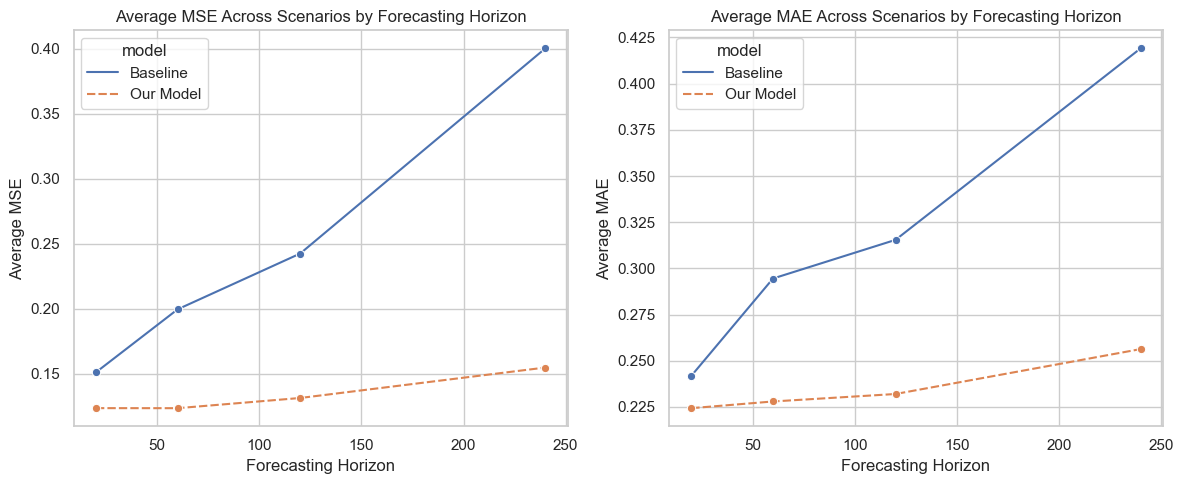

In [85]:

# Pivot the data for easier plotting
mse_pivot = avg_performance.pivot("forecasting_horizon", "model", "test_mse")
mae_pivot = avg_performance.pivot("forecasting_horizon", "model", "test_mae")

# Line plot for MSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=mse_pivot, marker='o')
plt.title('Average MSE Across Scenarios by Forecasting Horizon')
plt.ylabel('Average MSE')
plt.xlabel('Forecasting Horizon')

# Line plot for MAE
plt.subplot(1, 2, 2)
sns.lineplot(data=mae_pivot, marker='o')
plt.title('Average MAE Across Scenarios by Forecasting Horizon')
plt.ylabel('Average MAE')
plt.xlabel('Forecasting Horizon')

# Adjust layout
plt.tight_layout()
plt.show()

# Archived code

In [38]:
def get_configs_dict(cfg_file_path): 
    # Create a ConfigParser object
    config = configparser.ConfigParser()

    # Read the configuration file
    config.read(cfg_file_path)

    # Store the settings in a dictionary
    configs_dict = {}

    # Iterate over sections
    for section in config.sections():
        # Create a nested dictionary for each section
        configs_dict[section] = {}
        # Iterate over options in the section
        for option in config.options(section):
            # Get the value of the option
            value = config.get(section, option)
            # Check if the value is a string representation of a NumPy array
            if ',' in value:
                # Convert the string to a 1D NumPy array
                arr = value.split('\n')
                # Split the values by commas and convert each row to a NumPy array
                arr = np.array([row.split(',') for row in arr], dtype=float)
                # Store the NumPy array in the nested dictionary
                configs_dict[section][option] = arr
            else:
                # Store the value as-is in the nested dictionary
                configs_dict[section][option] = value
    return configs_dict

In [39]:
DATASET_LIST = ['GCS', 'SEQ', 'STADIUM_2023']
DATASET = DATASET_LIST[0]

if DATASET == 'GCS':
    trajs= parse_gcs("GCS/Annotation") # 35 seconds to load
    ZONE_LIST =[
        (0, 0, 28, 14),
        (28, 0, 55, 14),
        (0, 14, 28, 24),
        (28, 14, 55, 24),
        (0, 24, 28, 35),
        (28, 24, 55, 35),
        (0, 35, 28, 45),
        (28, 35, 55, 45),
        (0, 45, 55, 55)
    ]
    loader = GCSDatasetLoaderStatic(
        trajs=trajs,
        ZONE_LIST = ZONE_LIST)
if DATASET == 'SEQ': 
    configs_dict = get_configs_dict('SEQ.cfg')
    flow_df = pd.read_csv('flow_df_SEQ_1fps.csv')
    all_zone_dfs = [g for _,g in flow_df.groupby('egress_region')]
    loader = DatasetLoaderStatic(all_zone_dfs,
                                 configs_dict['CMGraph']['adjacency_mat'])
if DATASET == 'STADIUM_2023': 
    configs_dict = get_configs_dict('Stadium_2023.cfg')
    flow_df = pd.read_csv('flow_df_stadium_2023_1fps.csv')
    all_zone_dfs = [g for _,g in flow_df.groupby('egress_region')]
    loader = DatasetLoaderStatic(all_zone_dfs,
                                 configs_dict['CMGraph']['adjacency_mat'])

0it [00:00, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Construct CMGraph Given Egress Region Definitions

In [41]:
forecasting_horizon=20
dataset = loader.get_dataset(num_timesteps_in=forecasting_horizon, 
                             num_timesteps_out=forecasting_horizon)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(list(dataset)))
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f6984728d00>
Number of samples / sequences:  5173
Data(x=[9, 2, 20], edge_index=[2, 36], edge_attr=[36], y=[9, 20])


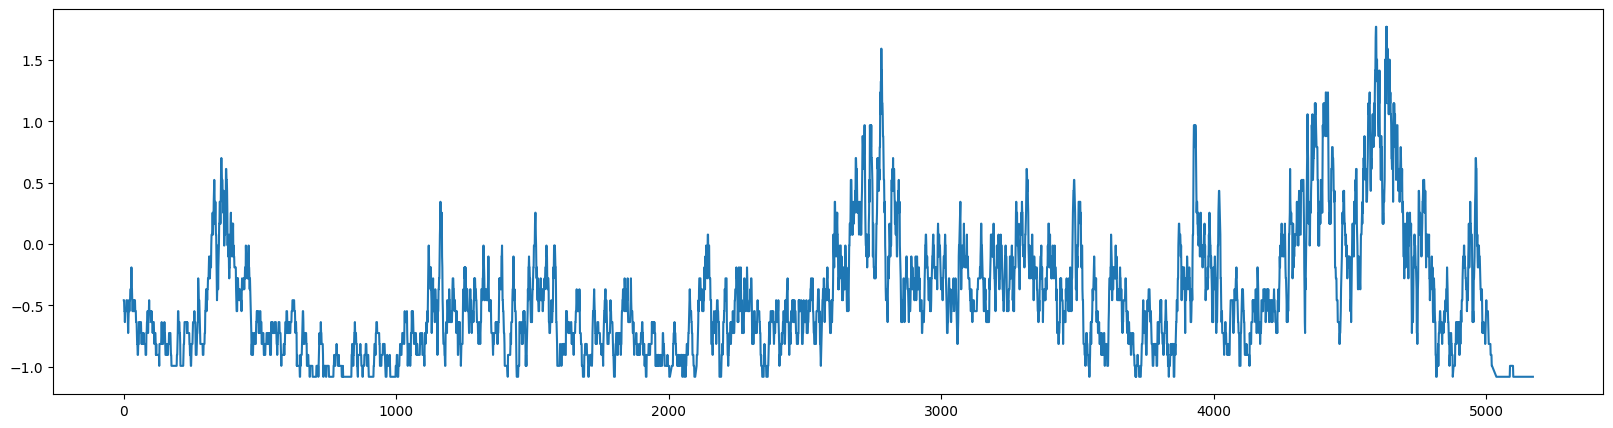

In [6]:
# Visualize traffic over time
plt.figure(figsize=(20,5))
zone_number = 2
time = -1
zone_labels = [bucket.y[zone_number][0].item() for bucket in list(dataset)[:time]]
plt.plot(zone_labels)

In [7]:
# # Visualize zones and trajectories
# from matplotlib.patches import Rectangle
# plt.gca().invert_yaxis()
# for traj in trajs: 
#     plt.plot(traj['pos_x'],traj['pos_y'],zorder=0)
    
# ax = plt.gca()
# for i,(x1,y1,x2,y2) in enumerate(ZONE_LIST): 
#     rect = Rectangle((x1,y1),
#                      x2-x1, 
#                      y2-y1, 
#                      alpha=0.3,
#                      facecolor=(0,0,0),
#                      edgecolor='r',
#                     )
#     ax.add_patch(rect)

# Split Train Test Set

In [42]:
batch_size = 32

input_np = np.array(dataset.features) 
target_np = np.array(dataset.targets) 
input_tensor = torch.from_numpy(input_np).type(torch.FloatTensor).to(device)  # (B, N, F, T)
target_tensor = torch.from_numpy(target_np).type(torch.FloatTensor).to(device)  # (B, N, T)
dataset_new = torch.utils.data.TensorDataset(input_tensor, target_tensor)

proportions = [0.7,0.3] # train: test ratio
lengths = [int(p * len(dataset_new)) for p in proportions]
lengths[-1] = len(dataset_new) - sum(lengths[:-1])
train_dataset_new, test_dataset_new = torch.utils.data.random_split(dataset_new, lengths, generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False)

print("Number of train buckets: ", len(list(train_dataset_new)))
print("Number of test buckets: ", len(list(test_dataset_new)))

Number of train buckets:  3621
Number of test buckets:  1552


# Train Model

In [9]:
%%time
'''
Select desired model here.
''' 
# model = GRU_only(in_channels=2, periods=20, batch_size=batch_size).to(device)
# model = GCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(device)
model = DenseGCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(device)
# model = A3TGCN_2(node_features=2, periods=20, batch_size=batch_size).to(device)
# model = TGCN_2(node_features=2, periods=20, batch_size=batch_size).to(device)

loss_fn = torch.nn.MSELoss()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(device)
    break;
    
# start training loop 
for epoch in range(40):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print("Epoch {} Step {} train MSE: {:.4f}".format(epoch, step, sum(loss_list)/len(loss_list)))
        step= step+ 1
            
    epoch_loss = sum(loss_list) / len(loss_list)
    epoch_losses.append(epoch_loss)
    print("Epoch {} Average Training MSE: {:.4f}".format(epoch, epoch_loss))

Epoch 0 Step 0 train MSE: 0.9915
Epoch 0 Step 100 train MSE: 0.2784
Epoch 1 Step 0 train MSE: 0.1045
Epoch 1 Step 100 train MSE: 0.1159
Epoch 2 Step 0 train MSE: 0.0846
Epoch 2 Step 100 train MSE: 0.1069
Epoch 3 Step 0 train MSE: 0.1026
Epoch 3 Step 100 train MSE: 0.1047
Epoch 4 Step 0 train MSE: 0.0976
Epoch 4 Step 100 train MSE: 0.1020
Epoch 5 Step 0 train MSE: 0.1034
Epoch 5 Step 100 train MSE: 0.1018
Epoch 6 Step 0 train MSE: 0.1120
Epoch 6 Step 100 train MSE: 0.1002
Epoch 7 Step 0 train MSE: 0.0968
Epoch 7 Step 100 train MSE: 0.0988
Epoch 8 Step 0 train MSE: 0.1039
Epoch 8 Step 100 train MSE: 0.0998
Epoch 9 Step 0 train MSE: 0.0844
Epoch 9 Step 100 train MSE: 0.0984
Epoch 10 Step 0 train MSE: 0.0869
Epoch 10 Step 100 train MSE: 0.0973
Epoch 11 Step 0 train MSE: 0.1127
Epoch 11 Step 100 train MSE: 0.0973
Epoch 12 Step 0 train MSE: 0.1186
Epoch 12 Step 100 train MSE: 0.0984
Epoch 13 Step 0 train MSE: 0.1009
Epoch 13 Step 100 train MSE: 0.0990
Epoch 14 Step 0 train MSE: 0.0857
Epoch 

# Saving and loading model checkpoints

In [10]:
filename = 'checkpoints/'+model.__class__.__name__+'_'+DATASET+'.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch_losses': epoch_losses,
            }, filename)
filename

'checkpoints/DenseGCNGRU_GCS.pt'

In [44]:
!ls checkpoints

DenseGCNGRU_GCS_120_steps.pt	       GCNGRU_SEQ_240_steps.pt
DenseGCNGRU_GCS_20_steps.pt	       GCNGRU_SEQ_60_steps.pt
DenseGCNGRU_GCS_240_steps.pt	       GCNGRU_STADIUM_2023_120_steps.pt
DenseGCNGRU_GCS_60_steps.pt	       GCNGRU_STADIUM_2023_20_steps.pt
DenseGCNGRU_SEQ_120_steps.pt	       GCNGRU_STADIUM_2023_240_steps.pt
DenseGCNGRU_SEQ_20_steps.pt	       GCNGRU_STADIUM_2023_60_steps.pt
DenseGCNGRU_SEQ_240_steps.pt	       GRU_only_GCS_120_steps.pt
DenseGCNGRU_SEQ_60_steps.pt	       GRU_only_GCS_20_steps.pt
DenseGCNGRU_STADIUM_2023_120_steps.pt  GRU_only_GCS_240_steps.pt
DenseGCNGRU_STADIUM_2023_20_steps.pt   GRU_only_GCS_60_steps.pt
DenseGCNGRU_STADIUM_2023_240_steps.pt  GRU_only_SEQ_120_steps.pt
DenseGCNGRU_STADIUM_2023_60_steps.pt   GRU_only_SEQ_20_steps.pt
GCNGRU_GCS_120_steps.pt		       GRU_only_SEQ_240_steps.pt
GCNGRU_GCS_20_steps.pt		       GRU_only_SEQ_60_steps.pt
GCNGRU_GCS_240_steps.pt		       GRU_only_STADIUM_2023_120_steps.pt
GCNGRU_GCS_60_steps.pt		       GRU_only_STADIUM_2

96916

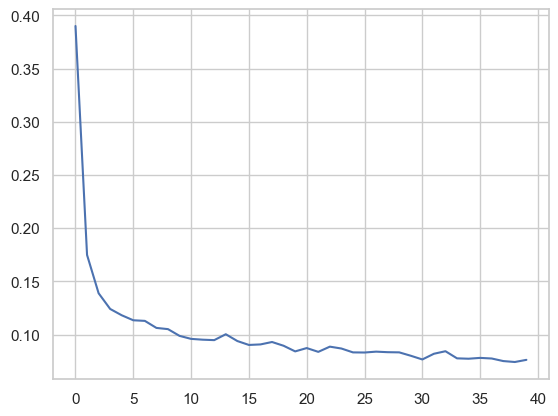

In [52]:
# load checkpoint
model = GCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(device)
checkpoint = torch.load('./checkpoints/GCNGRU_STADIUM_2023_20_steps.pt')
plt.plot(checkpoint['train_epoch_losses'])
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# print(model)

# model.train()
sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test

In [12]:
%%time
# testing loop 
loss_fn = torch.nn.MSELoss()
torch.no_grad()
model.eval()
# Store for analysis
total_loss = []
total_mae = []
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(device)
    break;

for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    mae = F.l1_loss(y_hat, labels)
    total_loss.append(loss.item())
    total_mae.append(mae.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    
#     # find sequence with most crowd count
#     if (labels>5.9).any():
#         break
            
        
print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))
print("Test MAE: {:.4f}".format(sum(total_mae)/len(total_mae)))
print(y_hat.shape)

Test MSE: 0.0901
Test MAE: 0.2100
torch.Size([16, 9, 20])
CPU times: user 3.72 s, sys: 3.92 ms, total: 3.72 s
Wall time: 471 ms


# Visualize results

In [175]:
def visualize_pivot_table(batch_df, initial_step, num_future_steps, return_instead_of_display=False):
    pd.set_option('precision', 3)
    fmin = initial_step
    fmax = step + num_future_steps
    df = batch_df.query('step >= @fmin and step <= @fmax')
    df = df[['step','egress_region','num_people_transformed']].pivot(
        index=['egress_region'], 
        columns='step', 
        values='num_people_transformed')
    df = df.dropna() # drop rows that contain missing values. 
    color_palette = sns.color_palette("vlag", as_cmap=True)
    if return_instead_of_display: 
        return df
    display(df.style.background_gradient(color_palette, axis = 0).applymap(lambda x : 'font-size:17.2px; font-weight:bold; opacity:0.9'))

In [176]:
visualize_pivot_table(df.query('is_output & batch==15'), 0, forecasting_horizon)
visualize_pivot_table(df.query('is_label & batch==15'), 0, forecasting_horizon)

In [99]:
%%time
B,N,D,T = encoder_inputs.shape
df_list = []
for b in range(B): 
    for n in range(N): 
        # append input
        data = encoder_inputs[b][n].cpu().numpy().transpose() # shape (T,2)
        df = pd.DataFrame(data, columns=["num_people_transformed", "timestamp_transformed"])
        df['batch'] = b
        df['egress_region'] = n
        df['is_input'],df['is_output'],df['is_label'] = (True, False, False)
        df_list.append(df.reset_index())
        # append output
        data = y_hat[b][n].detach().cpu().numpy().transpose() # shape (T)
        df = pd.DataFrame(data, columns=["num_people_transformed"])
        df['batch'] = b
        df['egress_region'] = n
        df['is_input'],df['is_output'],df['is_label'] = (False, True, False)
        df_list.append(df.reset_index())
        # append ground truth
        data = labels[b][n].cpu().numpy().transpose() # shape (T)
        df = pd.DataFrame(data, columns=["num_people_transformed"])
        df['batch'] = b
        df['egress_region'] = n
        df['is_input'],df['is_output'],df['is_label'] = (False, False, True)
        df_list.append(df.reset_index())
df = pd.concat(df_list)
df = df.rename(columns={'index':'step'})
df

CPU times: user 520 ms, sys: 4.01 ms, total: 524 ms
Wall time: 522 ms


step  num_people_transformed  timestamp_transformed  batch  egress_region  \
0      0               -0.993392               1.535650      0              0   
1      1               -1.082546               1.536315      0              0   
2      2               -1.082546               1.536979      0              0   
3      3               -1.082546               1.537644      0              0   
4      4               -1.052828               1.538309      0              0   
..   ...                     ...                    ...    ...            ...   
15    15                1.502913                    NaN     15              8   
16    16                1.413760                    NaN     15              8   
17    17                1.770375                    NaN     15              8   
18    18                1.770375                    NaN     15              8   
19    19                1.502913                    NaN     15              8   

    is_input  is_output  is_label  
0       True      False     False  
1       True      False     False  
2       True      False     False  
3       True      False     False  
4       True      False     False  
..       ...        ...       ...  
15     False      False      True  
16     False      False      True  
17     False      False      True  
18     False      False      True  
19     False      False      True  

[8640 rows x 8 columns]

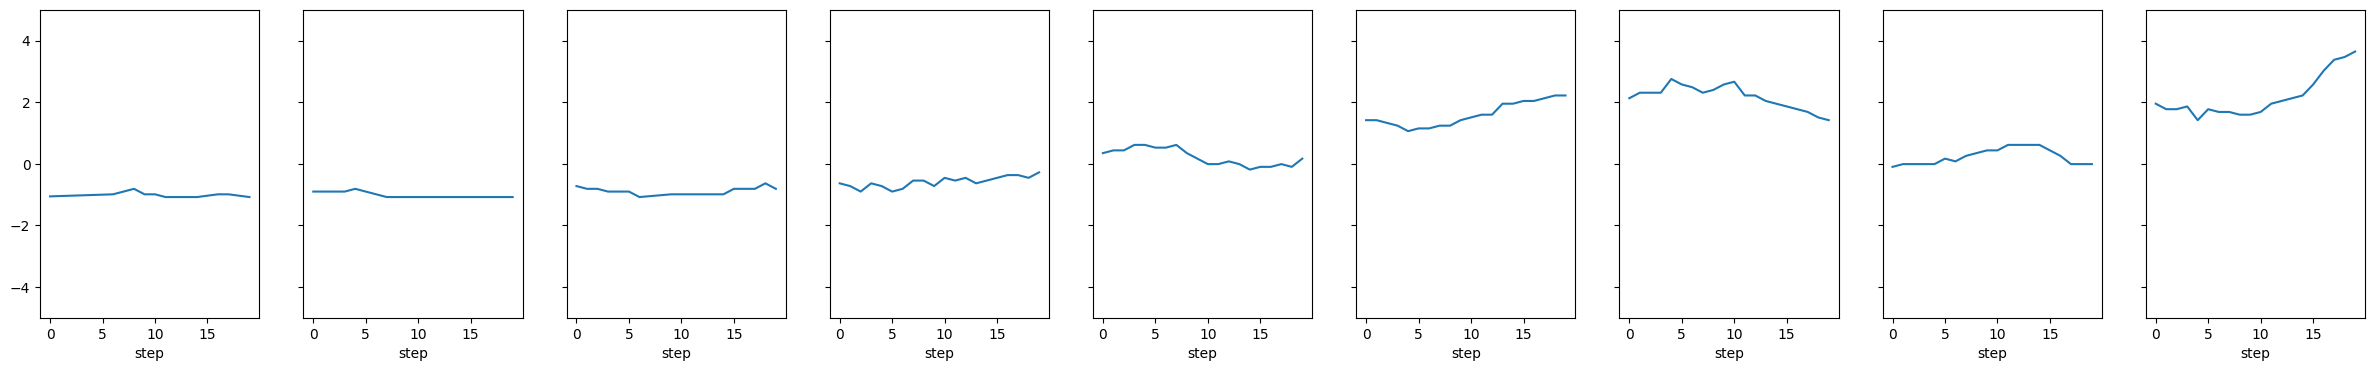

In [144]:
fig, axs = plt.subplots(1,N,figsize=(30,4))
for i,ax in enumerate(axs): 
    sample_input = df.query('is_input & batch==15 & egress_region==@i')[['step','num_people_transformed']]
    sample_input.plot(x='step',y='num_people_transformed',ax=ax,legend=False,ylim=(-5,5),sharey=True)

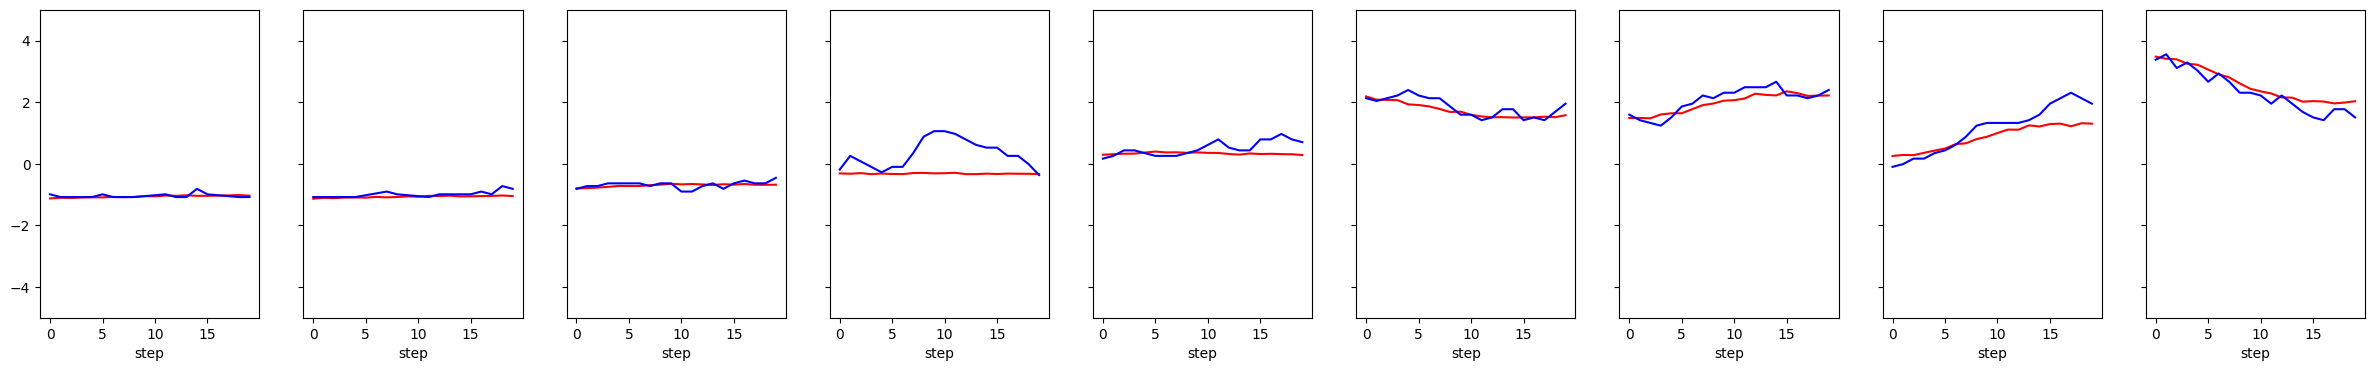

In [145]:
fig, axs = plt.subplots(1,N,figsize=(30,4))
for i,ax in enumerate(axs): 
    sample_output = df.query('is_output & batch==15 & egress_region==@i')[['step','num_people_transformed']]
    sample_output.plot(x='step',y='num_people_transformed',ax=ax,legend=False,ylim=(-5,5),sharey=True, color='r')
    sample_labels = df.query('is_label & batch==15 & egress_region==@i')[['step','num_people_transformed']]
    sample_labels.plot(x='step',y='num_people_transformed',ax=ax,legend=False,ylim=(-5,5),sharey=True, color='b')

# GAT experiment

In [13]:
from models import KLayerGAT

In [14]:
from torch_geometric.data import Batch, Data

'''
    GAT GRU model without dense connection
'''
class GATGRU(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,  
        periods: int, 
        heads: int,
        batch_size:int, 
        concat: bool = True,):
        super().__init__()

        self.in_channels = in_channels  # 2
        self.periods = periods # 12
        self.heads = heads
        self.concat = concat
        self.batch_size = batch_size
        self._setup_layers()

    def _setup_layers(self):
        self.gats = KLayerGAT( K=3,
                                   in_channels=self.in_channels,
                                   out_channels=128,
                                   heads=self.heads,
                                   concat=self.concat,
                                  )
        self.gru = torch.nn.GRU(128*self.heads,64,2,batch_first=True)
        self.fc = torch.nn.Linear(64, self.periods)

    def forward(self, 
                X: torch.FloatTensor,
                edge_index: torch.LongTensor, 
                edge_weight: torch.FloatTensor = None,
               ) -> torch.FloatTensor:
        gru_in = torch.zeros(X.shape[0],X.shape[1],self.periods,128).to(X.device) # (B,N,T,F_out_GCN)
        batch = Batch.from_data_list([Data(x=x, edge_index=edge_index, edge_weight=edge_weight) for x in encoder_inputs])
        for period in range(self.periods):
            gat_out = self.gats(X[:,:,:,period], edge_index, edge_weight)    
            gru_in[:,:,period,:] = gat_out
        gru_in = gru_in.flatten(start_dim=0, end_dim=1) # (B*N, T, F_out_GCN)
        gru_out, _ = self.gru(gru_in) # (B*N,T,H)
        out = self.fc(gru_out[:,-1,:]) # (B*N, Tout)
#         out = F.leaky_relu(out)
        out = out.view(X.shape[0], X.shape[1], self.periods, -1) # (B,N,Tout,1)
        return out.squeeze(dim=3) # (B,N,T)

In [15]:
%%time
'''
Select desired model here.
''' 
model = GATGRU(in_channels=2, periods=20, heads=1, batch_size=batch_size).to(device)

loss_fn = torch.nn.MSELoss()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(device)
    break;
    
for encoder_inputs, labels in train_loader:
    y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
    break
y_hat.shape

ModuleNotFoundError: 'CuGraphGATConv' requires 'pylibcugraphops'

In [39]:
batch =Batch.from_data_list([Data(x=x, edge_index=static_edge_index) for x in encoder_inputs])

In [35]:
batch.x.shape

torch.Size([288, 2, 20])

In [43]:
batch.x[:,:,0].shape

torch.Size([288, 2])

In [78]:
%autoreload

In [79]:
from torch_geometric.nn import CuGraphGATConv
layer = CuGraphGATConv(in_channels=2, out_channels=16)
res = layer(torch.randn([288,2]),edge_index = batch.edge_index.to('cpu'))

ModuleNotFoundError: 'CuGraphGATConv' requires 'pylibcugraphops'

In [70]:
res

tensor([[ 0.0379,  0.0609, -0.0477,  ..., -0.0297, -0.0637,  0.0012],
        [ 0.0439,  0.0720, -0.0626,  ..., -0.0316, -0.0793,  0.0021],
        [-0.0337, -0.0154, -0.1600,  ...,  0.1001, -0.0934,  0.0191],
        ...,
        [-0.0999, -0.0852, -0.2679,  ...,  0.2215, -0.1239,  0.0361],
        [-0.1789, -0.2038, -0.2118,  ...,  0.2990, -0.0233,  0.0379],
        [-0.0618, -0.0290, -0.2890,  ...,  0.1819, -0.1682,  0.0346]],
       grad_fn=<AddBackward0>)

In [ ]:
    
# start training loop 
for epoch in range(40):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print("Epoch {} Step {} train MSE: {:.4f}".format(epoch, step, sum(loss_list)/len(loss_list)))
        step= step+ 1

In [329]:
ZONE_NUM = 8

In [330]:
timestamps_normalized = encoder_inputs[BATCH_NUM,0,1,:].cpu()

In [331]:
start_index = ((loader.X[0,1] == timestamps_normalized[0]).nonzero(as_tuple=True)[0]).item()

In [332]:
period = len(timestamps_normalized)

In [333]:
A = loader.zone_dfs[ZONE_NUM].iloc[start_index:start_index+period][['num_people', 'timestamp']]

In [334]:
Y = loader.zone_dfs[ZONE_NUM].iloc[start_index+period:start_index+2*period][['num_people', 'timestamp']] # ground truth at T_obs... T_pred

In [335]:
T_pred = Y['timestamp'].iloc[-1]
T_0 = A['timestamp'].iloc[0]
pedestrian_df = pd.concat(trajs).query('@T_0 <= timestamp <= @T_pred')#.sort_values('timestamp')

In [336]:
loader.X[:,0,:].max()

tensor(5.9606)

In [337]:
encoder_inputs.shape

torch.Size([32, 9, 2, 20])

In [338]:
frame_id

98000

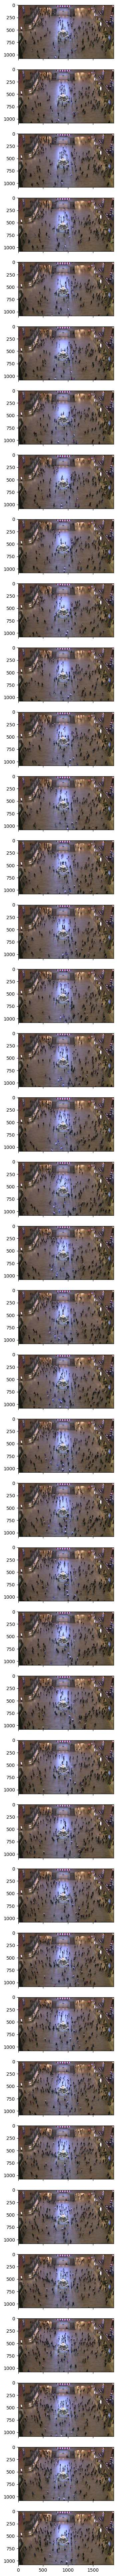

In [339]:
fig, axs = plt.subplots(len(groupby), 1, 
                        figsize=(5,100),
                        sharex='all',
                        sharey='all')
for ii,(_,df) in enumerate(groupby):
    frame_id = df['frame_id'].iloc[0]
    path = 'GCS/Frame/{:06d}.jpg'.format(frame_id)
    frame = cv2.imread(path)
    axs[ii].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
%%time
# sliding window over every frame
groupby = pedestrian_df.groupby('frame_id')
fig, axs = plt.subplots(len(groupby), 1, 
                        figsize=(5,100),
                        sharex='all',
                        sharey='all')
for ii,(_,df) in enumerate(groupby): 
    axs[ii].scatter(df['pos_x'],
                    -df['pos_y'])
    axs[ii].set_aspect('equal', 'box')
#     hm = HeatMap(df[['pos_x','pos_y']].values.astype(int).tolist())
# #                  width = 1200, height = 1200)
#     #              base=frame)#, base = img_path + 'IMG_' + str(img_num) + '.jpg')
#     axs[ii].imshow(np.fliplr(hm.heatmap(r=5)))
    
    # formatting stuff 
    axs[ii].xaxis.set_ticklabels([])
    axs[ii].yaxis.set_ticklabels([])
    axs[ii].set_title("Frame {}".format(ii))

CPU times: user 251 ms, sys: 61.3 ms, total: 312 ms
Wall time: 159 ms


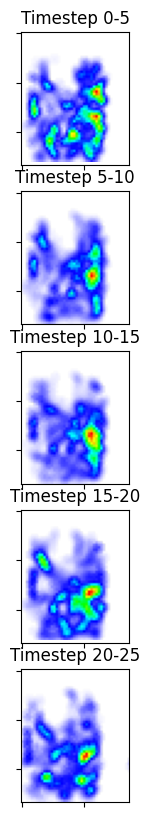

In [351]:
%%time
# sliding window over every frame
pedestrian_df['timestamp'] = pd.to_datetime(pedestrian_df['frame_id']//20, unit='s')
groupby = pedestrian_df.groupby(pd.Grouper(key='timestamp', freq='10s'))
fig, axs = plt.subplots(len(groupby), 1, 
                        figsize=(5,10),
                        sharex='all',
                        sharey='all')
for ii,(_,df) in enumerate(groupby): 
#     axs[ii].scatter(df['pos_x'],
#                     -df['pos_y'])
    axs[ii].set_aspect('equal', 'box')
    hm = HeatMap(df[['pos_x','pos_y']].values.astype(int).tolist())
#                  width = 1200, height = 1200)
    #              base=frame)#, base = img_path + 'IMG_' + str(img_num) + '.jpg')
    axs[ii].imshow(np.fliplr(hm.heatmap(r=2)))
    
    # formatting stuff 
    axs[ii].xaxis.set_ticklabels([])
    axs[ii].yaxis.set_ticklabels([])
    axs[ii].set_title("Timestep {}-{}".format(ii*5, 
                                          5+ii*5))

# Archived codes

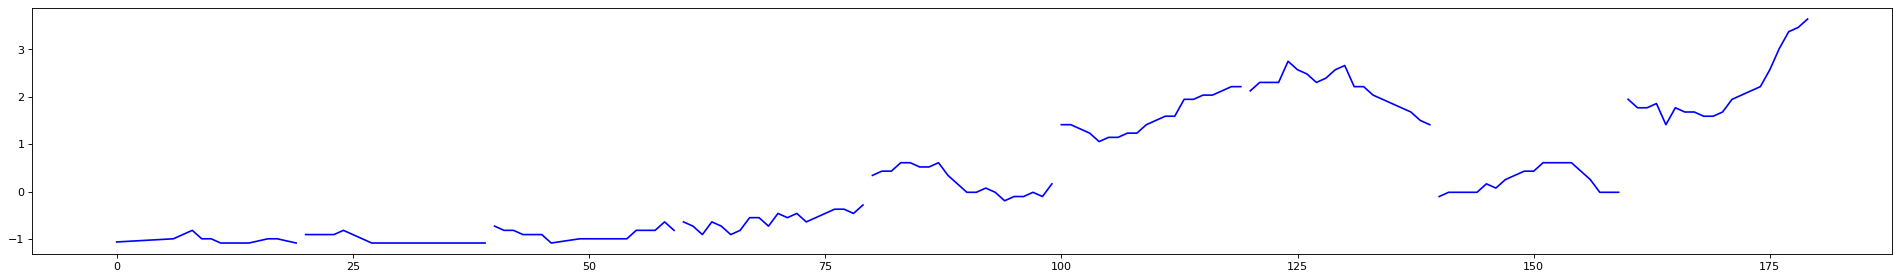

In [123]:
# visualize each egress region's crowd from one example sequence
BATCH_NUM=15
from matplotlib.pyplot import figure
sample_input = encoder_inputs[BATCH_NUM][:,0,:]
figure(figsize=(30,4), dpi=80)
for i in range(len(ZONE_LIST)):
    new_i = i * 20
    plt.plot(range(0+new_i,20+new_i),sample_input[i].cpu().numpy(), color='blue')
plt.show()

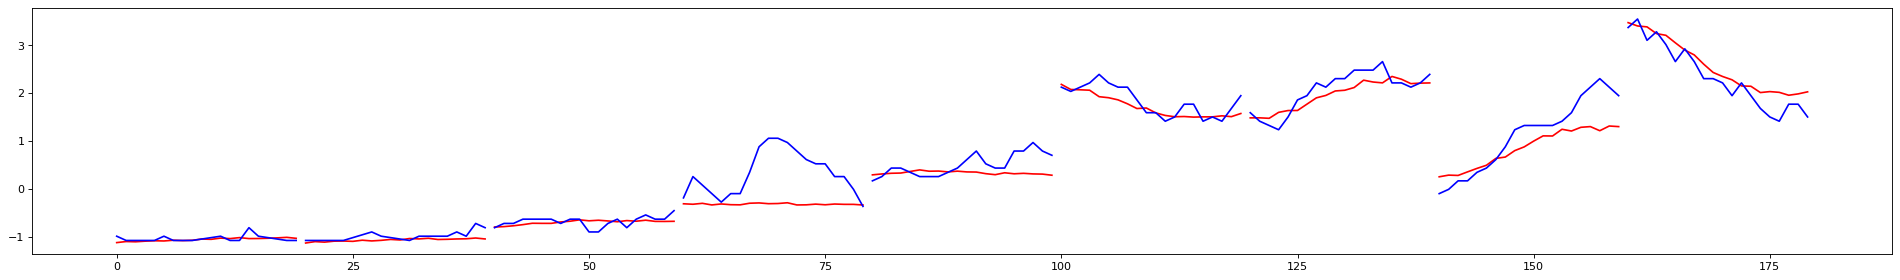

In [128]:
# visualize each egress region's crowd from one example sequence
from matplotlib.pyplot import figure
sample_output = y_hat[BATCH_NUM]
sample_labels = labels[BATCH_NUM] # (9, 20)
figure(figsize=(30,4), dpi=80)
for i in range(len(ZONE_LIST)):
    new_i = i * 20
    plt.plot(range(0+new_i,20+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,20+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()